In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load and preprocess data

In [53]:
# Load csv file 
pathomics_df = pd.read_csv("Processed data/pathomics_preprocessed.csv")
radiomics_df = pd.read_csv("Processed data/radiomics_preprocessed.csv")
transcriptomics_df = pd.read_csv("Processed data/transcriptomics_preprocessed.csv")

# Ensure patient-wise alignment by setting 'patient_id' as index
pathomics_df.set_index('patient_id', inplace=True)
radiomics_df.set_index("patient_id", inplace=True)
transcriptomics_df.set_index("patient_id", inplace=True)

# Find common patient IDs across all three datasets
common_patients = set(pathomics_df.index) & set(radiomics_df.index) & set(transcriptomics_df.index)
print(common_patients)

# Store patient list for indexing
common_patients = list(common_patients)  # Needed for indexing patient ID in dataset

# Filter datasets to keep only common patients
pathomics_df = pathomics_df.loc[common_patients]
radiomics_df = radiomics_df.loc[common_patients]
transcriptomics_df = transcriptomics_df.loc[common_patients] 

# Merge on patient_id (inner join to keep only common patients)
merged_df = pd.read_csv("Processed data/data_final_merged.csv")

# Separate data for each modality
pathomics_data = pathomics_df.to_numpy()
radiomics_data = radiomics_df.to_numpy()
transcriptomics_data = transcriptomics_df.to_numpy()

# Normalize each modality separately
scaler_path = StandardScaler().fit(pathomics_data)
scaler_radio = StandardScaler().fit(radiomics_data)
scaler_trans = StandardScaler().fit(transcriptomics_data)

pathomics_data = scaler_path.transform(pathomics_data)
radiomics_data = scaler_radio.transform(radiomics_data)
transcriptomics_data = scaler_trans.transform(transcriptomics_data)

# Convert to Pytorch tensor
pathomics_tensor = torch.tensor(pathomics_data, dtype=torch.float32)
radiomics_tensor = torch.tensor(radiomics_data, dtype=torch.float32)
transcriptomics_tensor = torch.tensor(transcriptomics_data, dtype=torch.float32)
print(f"pathomics tensor: {pathomics_tensor.shape}")
print(f"radiomics tensor: {radiomics_tensor.shape}")
print(f"transcriptomics tensor: {transcriptomics_tensor.shape}")

patient_list = list(common_patients)


{'patient_94', 'patient_10', 'patient_278', 'patient_126', 'patient_172', 'patient_254', 'patient_233', 'patient_116', 'patient_101', 'patient_260', 'patient_1', 'patient_9', 'patient_199', 'patient_249', 'patient_229', 'patient_41', 'patient_227', 'patient_242', 'patient_54', 'patient_256', 'patient_2', 'patient_174', 'patient_57', 'patient_156', 'patient_59', 'patient_21', 'patient_36', 'patient_257', 'patient_125', 'patient_88', 'patient_84', 'patient_103', 'patient_51', 'patient_279', 'patient_43', 'patient_61', 'patient_22', 'patient_5', 'patient_139', 'patient_121', 'patient_196', 'patient_60', 'patient_186', 'patient_144', 'patient_65', 'patient_17', 'patient_56', 'patient_194', 'patient_175', 'patient_48', 'patient_236', 'patient_38', 'patient_55', 'patient_224', 'patient_239', 'patient_50', 'patient_76', 'patient_86', 'patient_62', 'patient_246', 'patient_220', 'patient_148', 'patient_69', 'patient_180', 'patient_140', 'patient_151', 'patient_201', 'patient_70', 'patient_282',

### Custom dataset for contrastive learning

In [54]:
# Create dataset 
class MultiModalTripletDataset(Dataset):
    def __init__(self, pathomics, radiomics, transcriptomics, patient_list):
        self.pathomics = pathomics
        self.radiomics = radiomics
        self.transcriptomics = transcriptomics
        self.patient_list = patient_list  # Keep track of patients
        self.n_samples = len(self.patient_list)  # Use only common patients

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        """Returns (anchor, positive, negative) triplets."""

        # Get anchor sample (same patient across all modalities)
        anchor = (self.pathomics[idx], self.radiomics[idx], self.transcriptomics[idx])

        # Select a positive sample (same patient with slight augmentation)
        positive = (
            self.pathomics[idx] + 0.01 * torch.randn_like(self.pathomics[idx]),
            self.radiomics[idx] + 0.01 * torch.randn_like(self.radiomics[idx]),
            self.transcriptomics[idx] + 0.01 * torch.randn_like(self.transcriptomics[idx])
        )

        # Select a negative sample (ensure it comes from a different patient)
        neg_idx = np.random.randint(0, self.n_samples)
        while neg_idx == idx:  # Ensure negative sample is from a different patient
            neg_idx = np.random.randint(0, self.n_samples)

        negative = (
            self.pathomics[neg_idx],
            self.radiomics[neg_idx],
            self.transcriptomics[neg_idx]
        )

        return anchor, positive, negative


# Create DataLoader
dataset = MultiModalTripletDataset(pathomics_tensor, radiomics_tensor, transcriptomics_tensor, patient_list)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

### Define MLP Encoder

In [55]:
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=20):
        super(ModalityEncoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # Final embedding dimension
        )

    def forward(self, x):
        return self.model(x)

# Instantiate encoders for each modality
path_encoder = ModalityEncoder(input_dim=pathomics_tensor.shape[1]).to(device)
radio_encoder = ModalityEncoder(input_dim=radiomics_tensor.shape[1]).to(device)
trans_encoder = ModalityEncoder(input_dim=transcriptomics_tensor.shape[1]).to(device)

### Triplet Loss function

In [56]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=margin, p=2)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)

### Training function

In [61]:
def train_contrastive_model(dataloader, path_encoder, radio_encoder, trans_encoder, epochs=50, lr=0.001):
    optimizer = optim.Adam(list(path_encoder.parameters()) +
                        list(radio_encoder.parameters()) +
                        list(trans_encoder.parameters()), lr=lr, weight_decay=1e-4)
    criterion = TripletLoss().to(device)

    loss_history = []  # Store loss per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            (path_a, radio_a, trans_a), (path_p, radio_p, trans_p), (path_n, radio_n, trans_n) = batch
            path_a, radio_a, trans_a = path_a.to(device), radio_a.to(device), trans_a.to(device)
            path_p, radio_p, trans_p = path_p.to(device), radio_p.to(device), trans_p.to(device)
            path_n, radio_n, trans_n = path_n.to(device), radio_n.to(device), trans_n.to(device)

            optimizer.zero_grad()

            # Get modality embeddings
            anchor = torch.cat([path_encoder(path_a), radio_encoder(radio_a), trans_encoder(trans_a)], dim=1)
            positive = torch.cat([path_encoder(path_p), radio_encoder(radio_p), trans_encoder(trans_p)], dim=1)
            negative = torch.cat([path_encoder(path_n), radio_encoder(radio_n), trans_encoder(trans_n)], dim=1)

            # Compute triplet loss
            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)  # Store the average loss for this epoch

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return path_encoder, radio_encoder, trans_encoder, loss_history


In [62]:
trained_path_encoder, trained_radio_encoder, trained_trans_encoder, loss_history = train_contrastive_model(
    dataloader, path_encoder, radio_encoder, trans_encoder)

Epoch [1/50], Loss: 0.0000
Epoch [2/50], Loss: 0.0012
Epoch [3/50], Loss: 0.0000
Epoch [4/50], Loss: 0.0002
Epoch [5/50], Loss: 0.0000
Epoch [6/50], Loss: 0.0000
Epoch [7/50], Loss: 0.0000
Epoch [8/50], Loss: 0.0012
Epoch [9/50], Loss: 0.0000
Epoch [10/50], Loss: 0.0000
Epoch [11/50], Loss: 0.0000
Epoch [12/50], Loss: 0.0000
Epoch [13/50], Loss: 0.0007
Epoch [14/50], Loss: 0.0000
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0006
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0000
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Epoch [32/50], Loss: 0.0000
Epoch [33/50], Loss: 0.0012
Epoch [34/50], Loss: 0.0000
Epoch [35/50], Loss: 0.0000
Epoch [36/50], Loss: 0.0000
E

In [66]:
def plot_loss(loss_history):
    """
    Plots the training loss curve over epochs.

    Args:
        loss_history (list): A list of loss values recorded during training.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(loss_history) + 1), loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Contrastive Learning Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


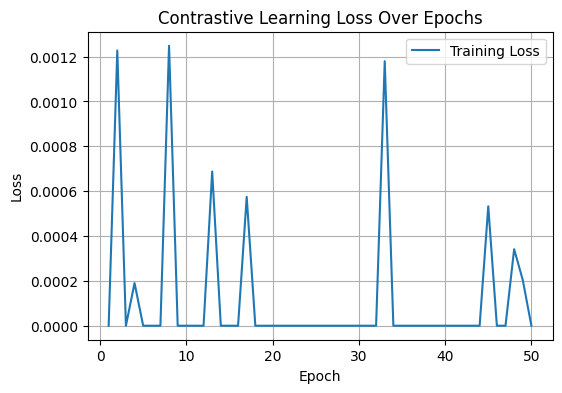

In [67]:
# Plot the loss curve
plot_loss(loss_history)

### Visualization: t-SNE

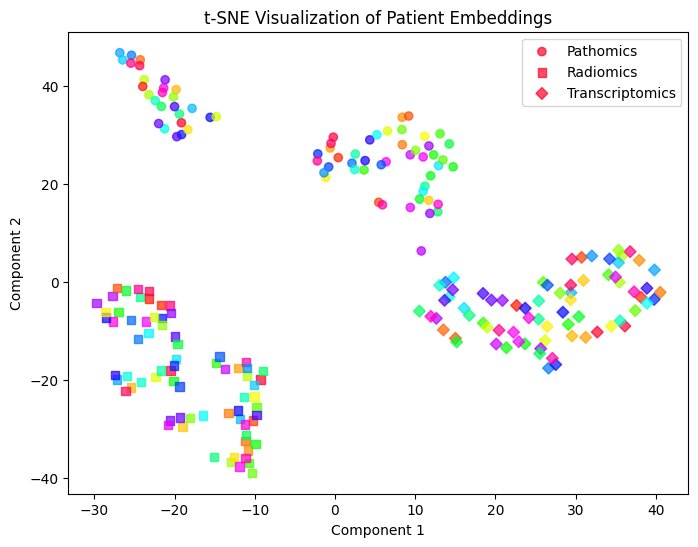

In [73]:
def visualize_embeddings_pca_tsne(model1, model2, model3, data_tensor1, data_tensor2, data_tensor3, patient_list):
    """
    Visualizes the learned embeddings using t-SNE.
    
    - Same patient embeddings (from different modalities) should cluster together.
    - Different patients should be well-separated.

    Args:
        model1, model2, model3: Trained modality encoders.
        data_tensor1, data_tensor2, data_tensor3: Data tensors for pathomics, radiomics, transcriptomics.
        patient_list: List of patient IDs corresponding to the data.
    """
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        embeddings_path = model1(data_tensor1.to(device)).cpu().numpy()
        embeddings_radio = model2(data_tensor2.to(device)).cpu().numpy()
        embeddings_trans = model3(data_tensor3.to(device)).cpu().numpy()

    # Concatenate all embeddings
    all_embeddings = np.concatenate([embeddings_path, embeddings_radio, embeddings_trans], axis=0)

    # Repeat patient labels for each modality
    patient_labels = np.array(patient_list)
    patient_labels = np.concatenate([patient_labels, patient_labels, patient_labels])

    # Create modality labels (1 = Pathomics, 2 = Radiomics, 3 = Transcriptomics)
    modality_labels = np.array(["Pathomics"] * len(embeddings_path) +
                               ["Radiomics"] * len(embeddings_radio) +
                               ["Transcriptomics"] * len(embeddings_trans))

    # Step 1: Apply t-SNE to project embeddings into 2D
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # Step 2: Assign colors based on patient ID
    unique_patients = sorted(set(patient_labels))
    color_palette = sns.color_palette("hsv", len(unique_patients))
    patient_color_map = {patient: color_palette[i] for i, patient in enumerate(unique_patients)}
    colors = np.array([patient_color_map[patient] for patient in patient_labels])

    # Step 3: Assign markers based on modality
    marker_map = {"Pathomics": "o", "Radiomics": "s", "Transcriptomics": "D"}
    markers = [marker_map[mod] for mod in modality_labels]

    # Step 4: Plot t-SNE embeddings
    plt.figure(figsize=(8, 6))
    for mod in ["Pathomics", "Radiomics", "Transcriptomics"]:
        mask = (modality_labels == mod)
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                    c=colors[mask], label=mod, alpha=0.7, marker=marker_map[mod])

    plt.title("t-SNE Visualization of Patient Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

# Run visualization
visualize_embeddings_pca_tsne(trained_path_encoder, trained_radio_encoder, trained_trans_encoder,
                    pathomics_tensor, radiomics_tensor, transcriptomics_tensor, patient_list)